In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize
import geojson
import os
from text_encoder import get_encode_fn
from pcd_to_geopandas import load_pcd_and_features, convert_to_lat_lon, coord_to_geopandas, aggregate_by_region
import utm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
lat_min, lat_max = -34.60311, -34.58030
lon_min, lon_max = -58.38346, -58.35933
print(f"{lon_min}, {lat_min}, {lon_max}, {lat_max}")

-58.38346, -34.60311, -58.35933, -34.5803


In [3]:
noise_map = gpd.read_file("noise_map_CABA/mapa_de_ruido_diurno/mapa_de_ruido_diurno.shp").to_crs(epsg=4326)
noise_map["noise_db"] = (noise_map["DB_HI"] + noise_map["DB_LO"]) / 2

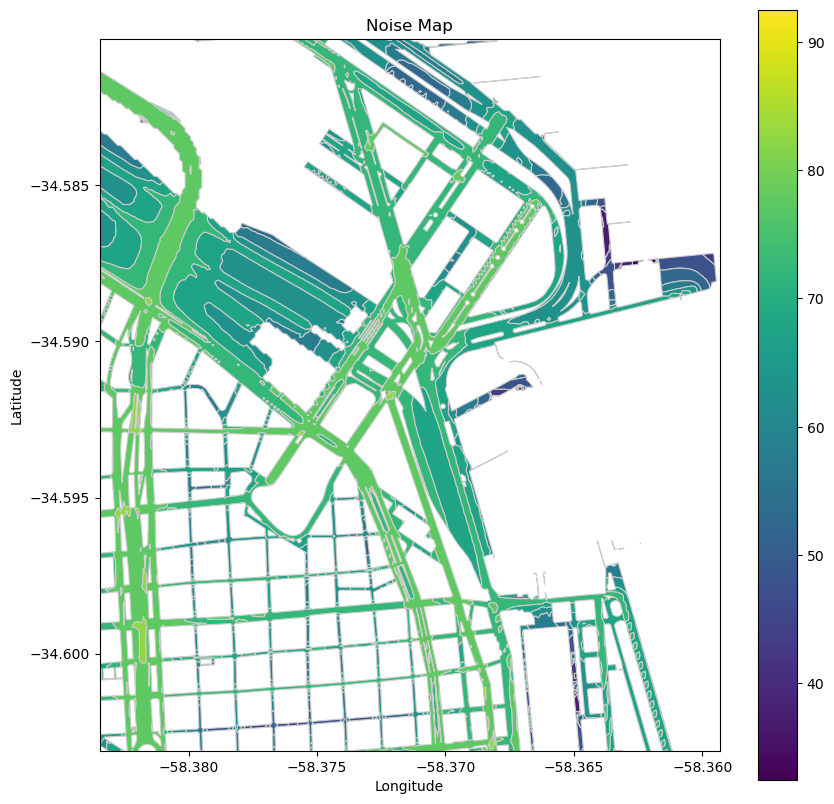

In [4]:
# Heat mapping of population density
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
gt_plot = noise_map.plot(column='noise_db', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Noise Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [5]:
tag = "buenos-aires-squared-v3"
crop_type = "highlight"
model_type = "siglip"
pcd, features, pcd_lat, pcd_lon = load_pcd_and_features(tag, crop_type)
model, tokenizer, encode_text = get_encode_fn(model_type=model_type)

(1000000, 1, 1152) (1000000, 3)


c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [102]:
queries = ["noisy urban area", "quiet area"]

query_embed = encode_text(queries, model, tokenizer)
sim = features @ query_embed 
sim = sim.max(axis=1)

# danger_ratio = sim[:,0] - (sim[:,1] + 0.1*sim[:,2])
# danger_ratio = np.exp(danger_ratio)
noise_ratio = np.exp(sim[:,0]) / np.exp(sim).sum(axis=1)
noise_ratio[(features[:,0] == 0).all(axis=1)] = np.min(noise_ratio[(features[:,0] != 0).any(axis=1)])

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [103]:
from visualization_utils import visualize
visualize(pcd, noise_ratio, "features")

In [104]:
predicted_noise_ratio = coord_to_geopandas(pcd_lat, pcd_lon, {"noise_ratio": noise_ratio}, resample_to_regular_grid=True)
joined = aggregate_by_region(noise_map, predicted_noise_ratio, prefix="pred_", project_on="points")

c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:85: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  pcd_points_gpd["geometry"] = pcd_points_gpd.apply(lambda row: Point(row['long'], row['lat']), axis=1)
c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [105]:
joined_nonzero = joined[joined["pred_n_points"] > 0]
correlation_per_point = joined_nonzero["noise_db"].corr(joined_nonzero["noise_ratio"], method='spearman')
correlation_per_point

0.19812380621450068

In [106]:
joined_by_district = aggregate_by_region(noise_map, predicted_noise_ratio, prefix="pred_", project_on="regions")
joined_nonzero_by_district = joined_by_district[joined_by_district["pred_n_points"] > 0]

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:97: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averages = grouped.mean()


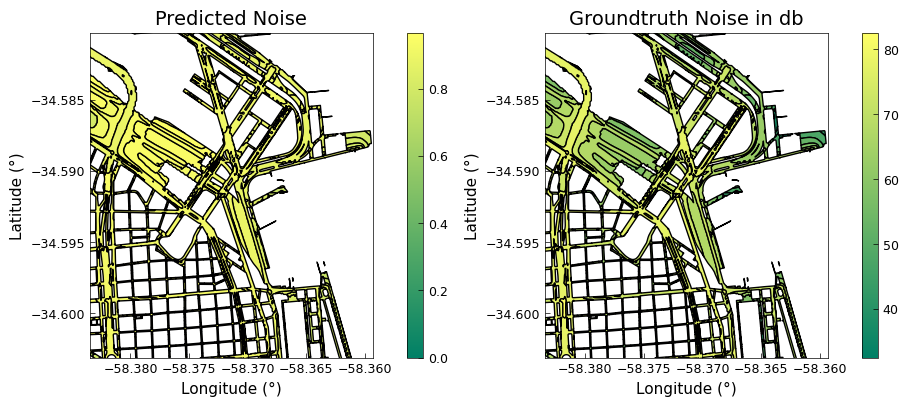

In [107]:
from visualization_utils import set_matplotlib_defaults
set_matplotlib_defaults()

fig, ax = plt.subplots(1, 2, figsize=(14 / 1.2, 5 / 1.2), tight_layout=True)
fig.patch.set_facecolor('white')
ax[0].set_facecolor('white')

joined_nonzero_by_district.plot(column="pred_avg_noise_ratio", ax=ax[0], legend=True,
             cmap="summer", edgecolor='black')
ax[0].set_xlim([lon_min, lon_max])
ax[0].set_ylim([lat_min, lat_max]) 
ax[0].set_title('Predicted Noise')
ax[0].set_xlabel('Longitude (°)')
ax[0].set_ylabel('Latitude (°)')
# ax[0].set_xticks(ax[0].get_xticks()[::2], labels=[f"{x:,.3f}" for x in ax[0].get_xticks()[::2]], rotation=45)
# ax[0].set_yticks(ax[0].get_yticks()[::2], labels=[f"{y:,.2f}" for y in ax[0].get_yticks()[::2]])


ax[1].set_facecolor('white')
joined_nonzero_by_district.plot(column='noise_db', ax=ax[1], legend=True,
             cmap="summer", edgecolor='black')
ax[1].set_xlim([lon_min, lon_max])
ax[1].set_ylim([lat_min, lat_max]) 
ax[1].set_title('Groundtruth Noise in db')
ax[1].set_xlabel('Longitude (°)')
ax[1].set_ylabel('Latitude (°)')

# ax[1].set_xticks(ax[1].get_xticks(), labels=[f"{x:,.3f}" for x in ax[1].get_xticks()], rotation=45)
# ax[1].set_yticks(ax[1].get_yticks(), labels=[f"{y:,.2f}" for y in ax[1].get_yticks()])
fig.savefig("noise_levels.pdf", dpi=1200)
# plt.suptitle(f'Predicted vd Heatmap of Point Density, Correlation: {correlation_per_district:.2f}')
plt.show()

## Few-shot Prediction

In [6]:
embedding_gdf = coord_to_geopandas(pcd_lat, pcd_lon, {"embeddings": list(features)}, resample_to_regular_grid=False)
embeddings_per_district = aggregate_by_region(noise_map.copy().explode().reset_index(), embedding_gdf, prefix="pred_", project_on="regions")
embeddings_per_district = embeddings_per_district[embeddings_per_district["pred_n_points"] > 0]

c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:85: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  pcd_points_gpd["geometry"] = pcd_points_gpd.apply(lambda row: Point(row['long'], row['lat']), axis=1)
C:\Users\Valentin\AppData\Local\Temp\ipykernel_22504\3088706603.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  embeddings_per_district = aggregate_by_region(noise_map.copy().explode().reset_index(), embedding_gd

In [19]:
train_df = embeddings_per_district.sample(frac=0.3, random_state=42)
test_df = embeddings_per_district.drop(train_df.index)

train_X = np.concatenate([x for x in train_df['pred_embeddings'].to_list() if isinstance(x, list) and len(x) > 0], axis=0)
train_y = np.concatenate([[age for _ in range(len(x))] for x, age in zip(train_df['pred_embeddings'].to_list(), train_df["noise_db"].to_list()) if isinstance(x, list) and len(x) > 0], axis=0)

test_X = np.concatenate([x for x in test_df['pred_embeddings'].to_list() if isinstance(x, list) and len(x) > 0], axis=0)
test_y = np.concatenate([[age for _ in range(len(x))] for x, age in zip(test_df['pred_embeddings'].to_list(), test_df["noise_db"].to_list()) if isinstance(x, list) and len(x) > 0], axis=0)
if len(test_X) > 20000:
    np.random.seed(42)
    random_indices = np.random.choice(len(test_X), 20000, replace=False)
    test_X = test_X[random_indices]
    test_y = test_y[random_indices]

print(test_X.shape, test_y.shape)
print(train_X.shape, train_y.shape)

(20000, 1, 1152) (20000,)
(86675, 1, 1152) (86675,)


In [25]:
len(test_df), len(train_df), len(embeddings_per_district), len(test_X), len(train_X)

(484, 207, 691, 20000, 86675)

In [22]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=50, metric='cosine')
print("Fitting")
knn.fit(train_X[:,0], train_y)
print("Predicting")
y_pred = knn.predict(test_X[:,0])

Fitting
Predicting


In [23]:
train_X[:,0].shape, train_y.shape

((86675, 1152), (86675,))

In [26]:
# eval
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

print(f"Mean squared error: {mean_squared_error(test_y, y_pred):.2f}")
print(f"R2 score: {r2_score(test_y, y_pred):.2f}")
print(f"Spearman corr {pd.Series(test_y).corr(pd.Series(y_pred), method='spearman'):.3f}")

Mean squared error: 50.36
R2 score: 0.11
Spearman corr 0.500
